In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
!pip install torchvision


In [2]:
!ls

drive  sample_data


In [3]:
cd "drive/MyDrive/projects/Brain Tumor Detection in Brain MRIs"

/content/drive/MyDrive/projects/Brain Tumor Detection in Brain MRIs


In [4]:
!ls

'Brain Tumor Detection using Brain MRIs.ipynb'	 data


In [6]:
import pandas as pd
import os
import torch
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from PIL import Image
import torch


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm


In [7]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

#Creating Train CSV File

In [8]:
images_path = "data/both/"

images_list = os.listdir(images_path)

splits = train_test_split(images_list, shuffle = True, test_size=0.2)

for i in splits[0]:
  f = open("data/train.txt", "a")
  f.write(i + "\n")
  f.close()

for i in splits[1]:
  f = open("data/test.txt", "a")
  f.write(i + "\n")
  f.close()


In [80]:
train_labels = [1 if x.startswith("Y") else 0 for x in splits[0]]
train_images = splits[0]
test_labels = [1 if x.startswith("Y") else 0 for x in splits[1]]
test_images = splits[1]

train_df = pd.DataFrame(columns=["img_name","label"])

train_df["img_name"] = train_images
train_df["label"] = train_labels
train_df

train_df.to_csv (r'data/train_csv.csv', index = False, header=True)

In [82]:
test_df = pd.DataFrame(columns=["img_name","label"])

test_df["img_name"] = test_images
test_df["label"] = test_labels
test_df

test_df.to_csv (r'data/test_csv.csv', index = False, header=True)

In [83]:
df = pd.read_csv("./data/test_csv.csv")

df.head()

,img_name,label
0,Y76.jpg,1
1,Y106.jpg,1
2,Y116.JPG,1
3,11 no.jpg,0
4,4 no.jpg,0


#Creating Custom Dataset Generator



In [11]:
class BrainTumorClassificationDataset(Dataset):
  def __init__(self, root_dir, annotation_file, transform=None):
    self.root_dir = root_dir
    self.annotations = pd.read_csv(annotation_file)
    self.transform = transform

    # print(root_dir, self.annotation_file)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    # print("I am here")
    img_id = self.annotations.iloc[index,0]
    img = Image.open(os.path.join(self.root_dir,img_id)).convert("RGB")
    y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

    if self.transform:
      img = self.transform(img)
    
    # print(img, y_label)
    return (img, y_label)

#Creating Model

In [90]:
import torch.nn as nn 
import torchvision.models as models

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)


In [91]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [93]:
model = model.to(device)

#Transformation

In [71]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

#Hyperparameters

In [72]:
train_CNN = False
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 1

# Dataloader Creation

In [84]:
root = "./data/both"
train_csv_path = "./data/train_csv.csv"
test_csv_path = "./data/test_csv.csv"

train_len = int(0.7*len(splits[0]))
valid_len = len(splits[0]) - train_len

print(train_len, valid_len)

dataset = BrainTumorClassificationDataset(root, csv_path, transform=transform)

print(dataset)

train_set, validation_set = torch.utils.data.random_split(dataset, [train_len, valid_len])
train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

test_dataset = BrainTumorClassificationDataset(root, test_csv_path, transform=transform)
test_loader = DataLoader(dataset=test_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)



141 61


In [74]:
import matplotlib.pyplot as plt


dataiter = iter(train_loader)
images, labels = dataiter.next()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


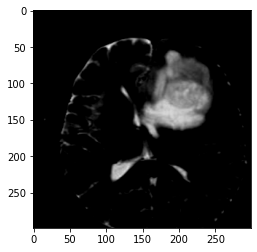

In [75]:
plt.imshow(images[2].permute(1,2,0))

#Training The Resnet Classifier

In [94]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("Correct: ", correct)
print("Total: ", total)

Accuracy of the network on the 10000 test images: 56 %
Correct:  29
Total:  51


In [95]:
model = model.to(device)

In [104]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


In [110]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        # running_loss = 0.0

    for data, labels in validation_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = criterion(target,labels.long())
        valid_loss = loss.item() * data.size(0)

    # print statistics
    if(epoch % 5 == 0 ):
        print("Running Loss: ", running_loss, "Valid Loss: ", valid_loss)
        
print('Finished Training')

Running Loss:  0.14611682295799255 Valid Loss:  12.698431253433228
Running Loss:  0.1915471851825714 Valid Loss:  10.700911492109299
Running Loss:  0.18310171365737915 Valid Loss:  10.443177461624146
Running Loss:  0.2719377875328064 Valid Loss:  6.1994666159152985
Running Loss:  0.6882051229476929 Valid Loss:  12.536585956811905


KeyboardInterrupt: ignored

In [111]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("Correct: ", correct)
print("Total: ", total)

Accuracy of the network on the 10000 test images: 92 %
Correct:  47
Total:  51
